In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

## 4 Special Moves

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
#special_probs = {"birth": 0.5, "death": 0.5}
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

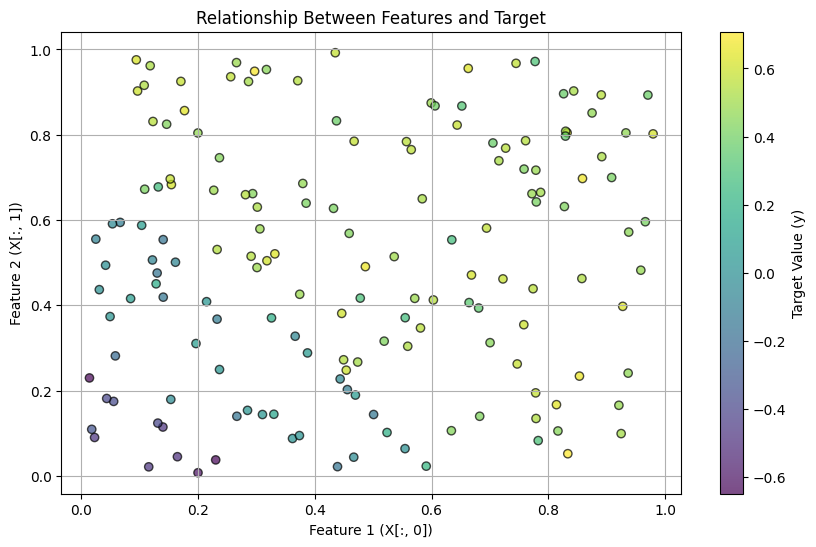

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
n_trees_ini = 50
nskip = 20000
ndpost = 1000
theta_0_nskip_prop=0.5
def temperature_schedule(t):
    t_start = theta_0_nskip_prop * nskip
    if t <= t_start:
        return 1.0
    else:
        t_max = (theta_0_nskip_prop+0.3) * nskip
        temp_min = 0.1
        temp = 1.0 - (t - t_start) * (1.0 - temp_min) / (t_max - t_start)
        return max(temp, temp_min)
bart = ChangeNumTreeBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees_ini, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0_ini = n_trees_ini, theta_0_min = 10, theta_0_nskip_prop=theta_0_nskip_prop, theta_df = 100, 
                         #temperature = TemperatureSchedule(temperature_schedule),
                         temperature = 1.0,
                         tree_num_prior_type="poisson", special_move_interval=5)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 21000/21000 [02:08<00:00, 163.87it/s]


In [5]:
bart.trace[-1].n_trees

31

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00677611]), 'ntree_theta': 15.029741548498302}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

29.64

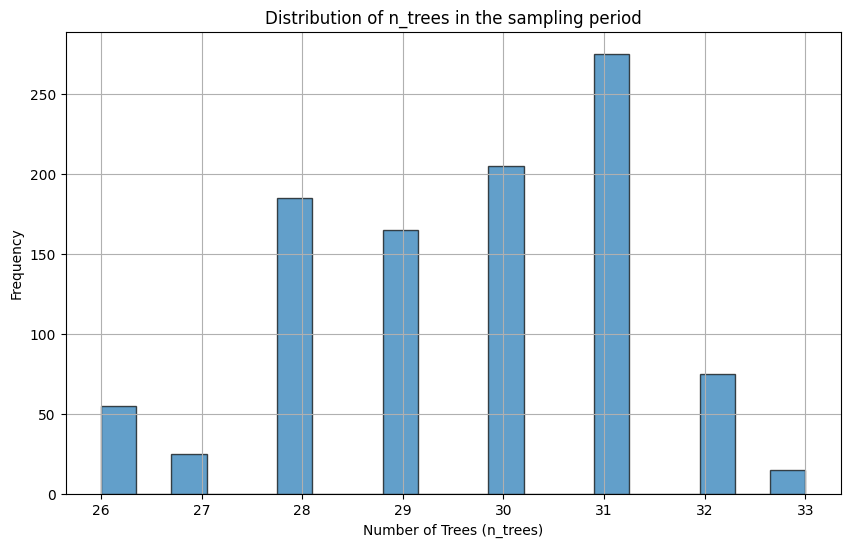

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

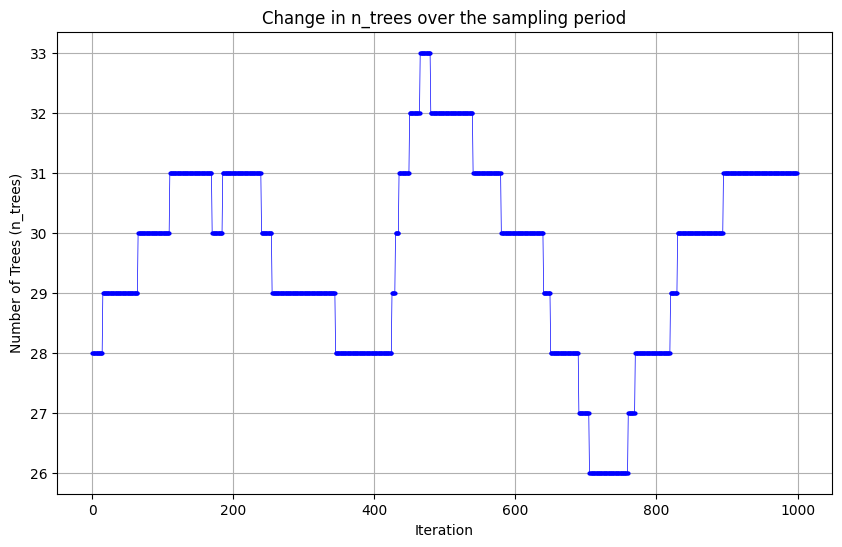

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
# Extract ntree_theta from global_params for each trace
ntree_theta_list = [trace.global_params['ntree_theta'] for trace in bart.trace]
np.mean(ntree_theta_list)

13.285798657575484

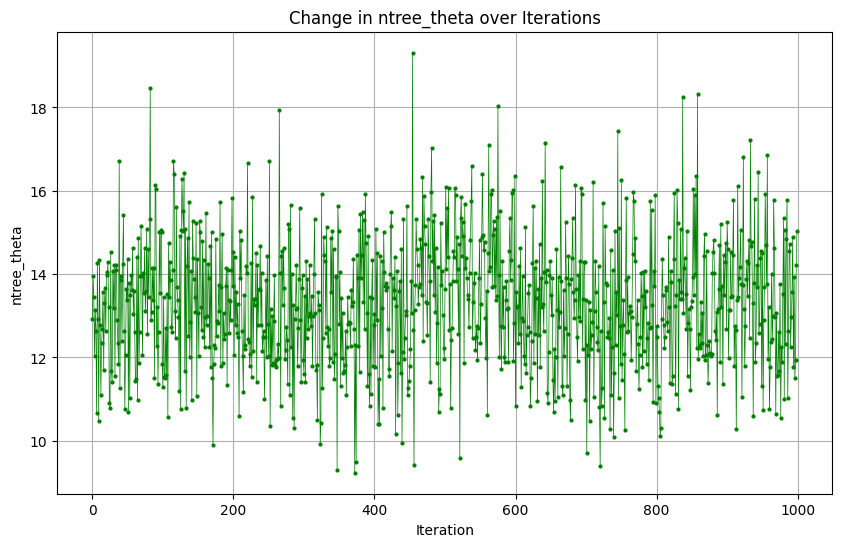

In [11]:
# Plot ntree_theta over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(ntree_theta_list)), ntree_theta_list, marker='o', markersize=2, linestyle='-', linewidth=0.5, color='g')
plt.title('Change in ntree_theta over Iterations')
plt.xlabel('Iteration')
plt.ylabel('ntree_theta')
plt.grid(True)
plt.show()

In [12]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=ndpost, nskip=200)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-05-22 13:45:50,777:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-22 13:45:50,782:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration  100/1200 P_grow=0.42 P_prune=0.58 A_grow=0.15 A_prune=0.56 (burnin)
Iteration  200/1200 P_grow=0.48 P_prune=0.52 A_grow=0.13 A_prune=0.31 (burnin)
Iteration  300/1200 P_grow=0.65 P_prune=0.35 A_grow=0.20 A_prune=0.36
Iteration  400/1200 P_grow=0.42 P_prune=0.58 A_grow=0.23 A_prune=0.22
Iteration  500/1200 P_grow=0.58 P_prune=0.42 A_grow=0.17 A_prune=0.54
Iteration  600/1200 P_grow=0.52 P_prune=0.48 A_grow=0.25 A_prune=0.27
Iteration  700/1200 P_grow=0.55 P_prune=0.45 A_grow=0.41 A_prune=0.50
Iteration  800/1200 P_grow=0.52 P_prune=0.48 A_grow=0.31 A_prune=0.13
Iteration  900/1200 P_grow=0.61 P_prune=0.39 A_grow=0.32 A_prune=0.33
Iteration 1000/1200 P_grow=0.48 P_prune=0.52 A_grow=0.33 A_prune=0.25
Iteration 1100/1200 P_grow=0.42 P_prune=0.58 A_grow=0.23 A_prune=0.44
Iteration 1200/1200 P_grow=0.55 P_prune=0.45 A_grow=0.18 A_prune=0.21


In [13]:
bart_default = DefaultBART(ndpost=ndpost, nskip=200, n_trees=ntree, proposal_probs=proposal_probs)
bart_default.fit(X_train, y_train)

Iterations: 100%|██████████| 1200/1200 [00:06<00:00, 189.95it/s]


In [14]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz,
          "bart_default" : bart_default}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.019436103289517875,
 'rf': 0.022940593791644048,
 'lr': 0.048045521328019404,
 'btz': 0.022320375517957344,
 'bart_default': 0.020226121899675917}

In [15]:
if all([(bart.sampler.trace[-1].trees[i].evaluate() == bart.sampler.trace[-1].trees[i].evaluate(X_train)).all()
            for i in range(bart.sampler.trace[-1].n_trees)]):
    print("True")
else:
    print("False")

True


In [16]:
np.allclose(bart.sampler.trace[-1].evaluate(X_train), bart.sampler.trace[-1].evaluate(), atol=1e-10, rtol=1e-12)

True

In [17]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 1071; mh median: 0.021075384016783442


In [18]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 46; mh median: 32.99556943855355


In [19]:
print(f'Break move count: {len(bart.sampler.break_mh_ratios)}; mh median: {np.median(bart.sampler.break_mh_ratios)}')

Break move count: 514; mh median: 0.324327250580428


In [20]:
print(f'Combine move count: {len(bart.sampler.combine_mh_ratios)}; mh median: {np.median(bart.sampler.combine_mh_ratios)}')

Combine move count: 829; mh median: 0.07719029240673038


In [21]:
print(bart.sampler.accepted_moves)

{'birth': 62, 'death': 38, 'break': 207, 'combine': 250}


In [22]:
bart.trace[-1].trees

[Tree(vars=[ 0  1 -1 -1 -1 -2 -2 -2], thresholds=[0.23257914 0.68702206        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan  0.03679324 -0.10797243  0.00641108         nan
          nan         nan], n_vals=[120  33  87  25   8  -2  -2  -2]),
 Tree(vars=[ 0 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.92718166        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.00117553 0.02209002        nan        nan        nan
         nan        nan], n_vals=[120 112   8  -2  -2  -2  -2  -2]),
 Tree(vars=[ 1 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.14290722        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.08485265 0.04994022        nan        nan        nan
         nan        nan], n_vals=[120  17 103  -2  -2  -2  -2  -2]),
 Tree(vars=[ 1 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.22963186        nan        nan        nan        nan        nan
         nan